In [23]:
%%capture --no-stderr
%pip install -U langgraph langchain_community langchain_anthropic langchain_experimental


In [24]:
import getpass
import os


def _set_if_undefined(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"Please provide your {var}")


_set_if_undefined("ANTHROPIC_API_KEY")
_set_if_undefined("TAVILY_API_KEY")


In [25]:
from typing import Literal, Annotated
from typing_extensions import TypedDict
from langchain_anthropic import ChatAnthropic
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import create_react_agent
from langchain_core.tools import tool
from langchain_experimental.utilities import PythonREPL
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import HumanMessage

import boto3

# Initialize LLM for agents
llm = ChatAnthropic(model="claude-3-5-sonnet-latest")

# DynamoDB Client
dynamodb_client = boto3.client("dynamodb", region_name="us-east-1")


In [26]:
@tool
def list_dynamodb_tables():
    """
    Lists all DynamoDB table names in the AWS account for the configured region.
    """
    dynamodb_client = boto3.client("dynamodb", region_name="us-east-1")

    try:
        response = dynamodb_client.list_tables()
        return {"success": True, "tables": response.get("TableNames", [])}
    except Exception as e:
        return {"success": False, "error": repr(e)}


In [27]:
@tool
def get_table_schema(table_name: Annotated[str, "The name of the DynamoDB table."]):
    """
    Fetches the schema (key attributes and other metadata) of a specific DynamoDB table.
    """
    dynamodb_client = boto3.client("dynamodb", region_name="us-east-1")

    try:
        response = dynamodb_client.describe_table(TableName=table_name)
        table_description = response.get("Table", {})
        return {
            "success": True,
            "schema": {
                "TableName": table_description.get("TableName"),
                "KeySchema": table_description.get("KeySchema"),
                "AttributeDefinitions": table_description.get("AttributeDefinitions"),
                "ProvisionedThroughput": table_description.get("ProvisionedThroughput"),
                "GlobalSecondaryIndexes": table_description.get(
                    "GlobalSecondaryIndexes", []
                ),
                "LocalSecondaryIndexes": table_description.get(
                    "LocalSecondaryIndexes", []
                ),
            },
        }
    except Exception as e:
        return {"success": False, "error": repr(e)}


In [28]:
@tool
def query_dynamodb_with_context(
    user_input: Annotated[str, "The user input describing the query details."]
):
    """
    Dynamically queries or suggests scanning a DynamoDB table based on user input.
    If no key condition is provided, suggest scanning the table instead.
    """
    try:
        # Parse user input (basic example, extendable with NLP if needed)
        if "table" not in user_input:
            return {"success": False, "error": "Input must specify a table name."}

        # Extract table name
        table_name = (
            user_input.split("table")[1].split("where")[0].strip(" '").strip('"')
        )

        # Check if a condition is provided
        if "where" in user_input:
            condition = user_input.split("where")[1].strip()

            # Parse condition (e.g., "OrderID = 123")
            if "=" not in condition:
                return {
                    "success": False,
                    "error": "Condition must include '=' for key filtering.",
                }

            key_name, key_value = [x.strip() for x in condition.split("=")]
            key_value = key_value.strip("'\"")  # Handle quotes in input

            # Construct query parameters
            query_params = {
                "TableName": table_name,
                "KeyConditionExpression": f"{key_name} = :value",
                "ExpressionAttributeValues": {":value": {"S": key_value}},
            }

            # Query the table
            response = dynamodb_client.query(**query_params)

            return {
                "success": True,
                "data": response.get("Items", []),
            }

        else:
            # No condition is provided, suggest using the scan tool
            return {
                "success": False,
                "error": "No condition provided. Use the scan_dynamodb_table tool to retrieve all items.",
            }

    except Exception as e:
        return {"success": False, "error": repr(e)}


In [29]:
@tool
def scan_dynamodb_table(
    table_name: Annotated[str, "The name of the DynamoDB table to scan."]
):
    """
    Scans a DynamoDB table and retrieves all items.
    Use this tool when no specific condition is provided in the user input.
    """
    try:
        # Perform the scan operation
        response = dynamodb_client.scan(TableName=table_name)
        return {
            "success": True,
            "data": response.get("Items", []),
        }
    except Exception as e:
        return {"success": False, "error": repr(e)}


In [30]:
@tool
def python_repl_tool(
    code: Annotated[
        str, "The Python code to execute for processing or chart generation."
    ]
):
    """
    Executes Python code locally. Useful for processing DynamoDB query results or performing computations.
    """

    repl = PythonREPL()
    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    return f"Successfully executed:\n```python\n{code}\n```\nStdout: {result}"


In [31]:
import os
import json


@tool
def json_converter(
    data: Annotated[dict, "The DynamoDB output data to convert and save as JSON"],
    file_name: Annotated[str, "The name of the output JSON file."],
):
    """
    Converts the given DynamoDB output into JSON format and saves it in the `output` directory
    with the specified file name.
    """
    try:
        # Ensure the output directory exists
        os.makedirs("output", exist_ok=True)

        # Construct the full file path
        output_file = os.path.join("output", file_name)

        # Save the data as JSON
        with open(output_file, "w") as f:
            json.dump(data, f, indent=4)

        return {
            "success": True,
            "message": f"Data successfully saved to {output_file}.",
        }
    except Exception as e:
        return {
            "success": False,
            "error": f"Failed to save data as JSON. Error: {repr(e)}",
        }


In [32]:
from langgraph.graph import MessagesState


In [33]:
# The agent state is the input to each node in the graph
class AgentState(MessagesState):
    # The 'next' field indicates where to route to next
    next: str


In [34]:
from typing import Literal
from typing_extensions import TypedDict

from langchain_anthropic import ChatAnthropic
from langgraph.graph import MessagesState

# Define team members and task options
members = ["dynamodb_researcher", "dynamodb_coder", "json_converter"]
options = members + ["FINISH"]

# Supervisor system prompt
system_prompt = (
    "You are a supervisor tasked with managing a conversation between the"
    f" following workers: {members}. Given the following user request and"
    " the progress of each worker, decide the next worker to act or whether"
    " the task is completed. Each worker will perform a task and respond with"
    " their results and status and then respond with FINISH."
)


class Router(TypedDict):
    """Worker to route to next. If no workers are needed, route to FINISH."""

    next: Literal[*options]


# Initialize the supervisor LLM
llm = ChatAnthropic(model="claude-3-5-sonnet-latest")


def supervisor_node(state: AgentState) -> AgentState:
    """
    Supervisor node dynamically decides the next worker to act based on
    the current state of the workflow.
    """
    # Construct the prompt for the supervisor with context from current state
    messages = [
        {"role": "system", "content": system_prompt},
    ] + state["messages"]
    response = llm.with_structured_output(Router).invoke(messages)
    next_ = response["next"]
    if next_ == "FINISH":
        next_ = END

    return {"next": next_}


In [35]:
research_agent = create_react_agent(
    llm,
    tools=[
        list_dynamodb_tables,
        get_table_schema,
        query_dynamodb_with_context,
        scan_dynamodb_table,
    ],
    state_modifier="You are a researcher. Use tools to fetch DynamoDB tables, schemas, and data.",
)


In [36]:
json_converter_agent = create_react_agent(
    llm,
    tools=[json_converter],
    state_modifier="You are a data processor. Use the JSON converter tool to process DynamoDB output and save it as a file.",
)


In [37]:
def research_node(state: AgentState) -> AgentState:
    """
    Researcher node uses DynamoDB tools to fetch tables, schemas, or query data.
    Hands control back to the supervisor after completion.
    """
    result = research_agent.invoke(state)
    return {
        "messages": [
            HumanMessage(
                content=result["messages"][-1].content, name="dynamodb_researcher"
            )
        ]
    }


coder_agent = create_react_agent(
    llm,
    tools=[python_repl_tool],
    state_modifier="You are a coder. Use tools to process and analyze DynamoDB data using Python.",
)


def json_converter_node(state: AgentState) -> AgentState:
    result = json_converter_agent.invoke(state)
    return {
        "messages": [
            HumanMessage(content=result["messages"][-1].content, name="json_converter")
        ]
    }


In [38]:
def code_node(state: AgentState) -> AgentState:
    result = coder_agent.invoke(state)
    return {
        "messages": [
            HumanMessage(content=result["messages"][-1].content, name="dynamodb_coder")
        ]
    }


In [39]:
builder = StateGraph(MessagesState)
builder.add_edge(START, "supervisor")
builder.add_node("supervisor", supervisor_node)
builder.add_node("dynamodb_researcher", research_node)
builder.add_node("json_converter", json_converter_node)
builder.add_node("dynamodb_coder", code_node)


In [40]:
for member in members:
    # We want our workers to ALWAYS "report back" to the supervisor when done
    builder.add_edge(member, "supervisor")

# The supervisor populates the "next" field in the graph state
# which routes to a node or finishes
builder.add_conditional_edges("supervisor", lambda state: state["next"])
# Finally, add entrypoint
builder.add_edge(START, "supervisor")

graph = builder.compile()


In [41]:
from IPython.display import display, Image


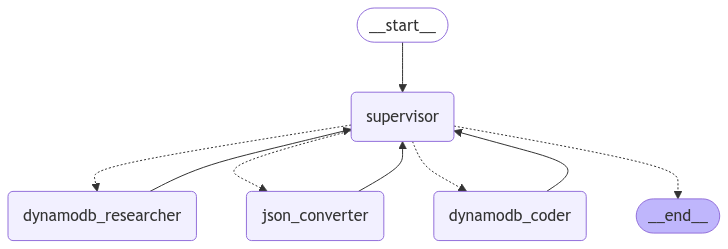

In [42]:
display(Image(graph.get_graph().draw_mermaid_png()))


In [43]:
for s in graph.stream(
    {
        "messages": [
            (
                "user",
                "Retrieve data from any dynamodb table in my account and calculate the number of rows in the data, and give me the result in a json file in output folder ",
            )
        ]
    },
    subgraphs=True,
):
    print(s)
    print("----")


((), {'supervisor': {'next': 'dynamodb_researcher'}})
----
(('dynamodb_researcher:2d30688f-ac53-a5e7-fd96-d00a11d69adc',), {'agent': {'messages': [AIMessage(content=[{'text': "I'll help you retrieve and analyze the data from DynamoDB tables. Let's break this down into steps:\n\n1. First, let's list all available DynamoDB tables in your account:", 'type': 'text'}, {'id': 'toolu_01SLfaWpzzZqwWw9QsY9NAgU', 'input': {}, 'name': 'list_dynamodb_tables', 'type': 'tool_use'}], additional_kwargs={}, response_metadata={'id': 'msg_01PuuyA9UAQTFb2LsJVbYqvo', 'model': 'claude-3-5-sonnet-20241022', 'stop_reason': 'tool_use', 'stop_sequence': None, 'usage': {'input_tokens': 711, 'output_tokens': 81}}, id='run-4f4b964f-42d5-4d4b-b0ad-e33532307ac5-0', tool_calls=[{'name': 'list_dynamodb_tables', 'args': {}, 'id': 'toolu_01SLfaWpzzZqwWw9QsY9NAgU', 'type': 'tool_call'}], usage_metadata={'input_tokens': 711, 'output_tokens': 81, 'total_tokens': 792, 'input_token_details': {}})]}})
----
(('dynamodb_researc